In [1]:
# load encoding model learned receptive fields
import sys 
sys.path.append('../encoding/') # Adds to the end of the list

import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from dataloader import get_stimulus_datasets, get_dataloaders
from pathlib import Path
from train import train_model
from torch.utils.data import Subset
import numpy as np

from model import get_pretrained_model
from utils import set_seed
from model import VideoModel
import numpy as np
import argparse
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from scipy.ndimage import center_of_mass

# Load the dataframe
with open("../dataset/dorsal_stream_neuron_table.pickle", "rb") as f:
    df = pickle.load(f)

session_ids = df['session_id'].unique()

name = "dorsal_stream"
layer = "layer2"
num_neurons = 2244
input_size = 224
input_shape_to_readout = 56 # verify this matches below
pretrained_model = get_pretrained_model("r3d18")
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VideoModel(pretrained_model, layer, num_neurons, device, input_shape=(1, 3, 5, input_size, input_size)).to(device)

load_path = Path(f'../encoding/checkpoints/dorsal_stream_r3d18_224_layer2.pth')

net.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))

all_neurons = net.w_s.shape[0]
map_size = net.w_s[0].numel()  # assuming each neuron's weights are flattened
map_dim = int(np.sqrt(map_size))  # assuming square receptive fields

input shape to readout: torch.Size([1, 128, 3, 56, 56])


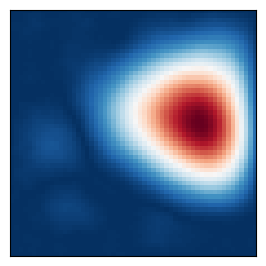

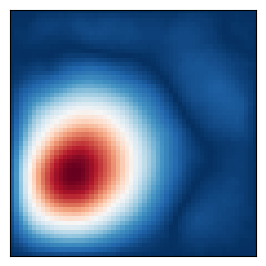

In [2]:
# GET EXAMPLE RFS for two neurons & example learned feature map coordinates 
import matplotlib 

neuron_uids = [350, 850]
session_mask1 = df['neuron_uid'] == neuron_uids[0]
session_mask2 = df['neuron_uid'] == neuron_uids[1]

for i in range(2):
    if i == 0:
        session_mask = session_mask1
    else:
        session_mask = session_mask2
            
    plt.figure(figsize=(3.2, 3.2))

    arr = np.abs(net.w_s[df.loc[session_mask]['neuron_uid'].item()].squeeze().detach().cpu().numpy())
    arr = arr - arr.min()
    arr = arr/arr.max()
    arr_2d = arr.reshape(map_dim, map_dim)

    plt.imshow(np.abs(arr_2d), cmap='RdBu_r')
    plt.clim([0,1])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"figures/example_ws_{neuron_uids[i]}.pdf")
    plt.show()

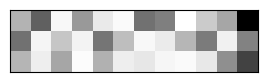

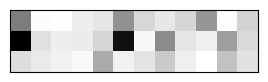

In [3]:
T = 3
C = 128

for i in range(2):
    if i == 0:
        session_mask = session_mask1
    else:
        session_mask = session_mask2

    
    plt.figure(figsize=(3.2, 3.2))

    arr = np.abs(net.w_f[:, df.loc[session_mask]['neuron_uid'].item()].squeeze().detach().cpu().view(C,T).numpy()).T
    arr = arr - arr.min()
    arr = arr/arr.max()

    plt.imshow(arr[:, 36:48], cmap='Grays')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"figures/example_wf_{neuron_uids[i]}.pdf")
    plt.show()

In [4]:
# test model & plot predictions for these two neurons
# load encoding model learned receptive fields
import sys 
sys.path.append('../encoding/') # Adds to the end of the list

import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from dataloader import get_stimulus_datasets, get_dataloaders
from pathlib import Path
from train import train_model
from torch.utils.data import Subset
import numpy as np

from model import get_pretrained_model
from utils import set_seed
from model import VideoModel
import numpy as np
import argparse
import pickle

stimulus_size = 224
batch_size = 40
modality = 'video'

train_dataset, test_dataset = get_stimulus_datasets(name, modality=modality, stimulus_size=stimulus_size)

train_loader, val_loader, test_loader = get_dataloaders(train_dataset, test_dataset, batch_size=batch_size, val_prop=0.1, seed=42)


# put model in eval mode so that BN gets evaluated properly 
net.eval()

net.to(device)

# aggregate output and labels for test set 
outputs = []
labels = []
for data, label in test_loader:
    if torch.sum(torch.isnan(data)) == torch.numel(data):
        continue
    data = data.to(device)
    label = label.to(device)
    output = net(data)
    
    # ignore nans
    nan_idx = torch.isnan(label)
    output[nan_idx] = 0
    label[nan_idx] = 0

    output = output.squeeze()

    outputs.append(output)
    labels.append(label)

outputs = torch.row_stack(outputs).detach().cpu()
labels = torch.row_stack(labels).detach().cpu()

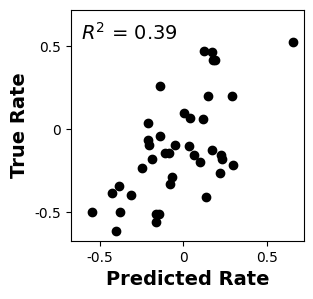

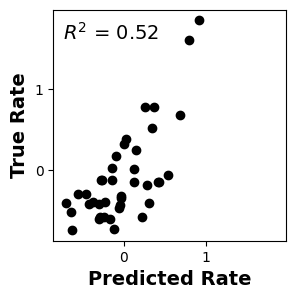

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

ticks = [(-0.5,0, 0.5), (0, 1)]
cnt = 0
for i in neuron_uids:
    plt.figure(figsize=[3,3])
    ax = plt.gca()
    plt.scatter(outputs[:, i].unsqueeze(1), labels[:, i].unsqueeze(1), color='k')
    r2 = pearsonr(outputs[:, i].unsqueeze(1), labels[:, i].unsqueeze(1)).statistic ** 2
    plt.xlabel("Predicted Rate", fontweight='bold', fontsize=14)
    plt.ylabel("True Rate", fontweight='bold', fontsize=14)
    r2_val = round(r2[0], 2)

    plt.xticks(ticks = ticks[cnt], labels=ticks[cnt])
    plt.yticks(ticks = ticks[cnt], labels=ticks[cnt])

    min_lim = min(plt.ylim()[0], plt.xlim()[0])
    max_lim = max(plt.ylim()[1], plt.xlim()[1])
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)

    plt.text(0.25, 0.9, "$R^2$ = " + str(r2_val), transform = ax.transAxes, ha='center', va='center', fontsize=14)
    plt.savefig(f"figures/model_preds{i}.pdf", bbox_inches='tight')
    plt.show()
    cnt += 1